## 2.1 简介

有一个拥有 K 根拉杆的老虎机, 每拉动一根拉杆都有一定的几率获得一定的奖励. 每根拉杆的获奖概率是不同且未知的, 如何在有限的游戏次数内获得最大的累积奖励?

分析问题我们发现, 这需要我们在 "探索每根拉杆的获奖概率" 和 "只拉动获奖概率最大的那根拉杆" 之间进行权衡


In [2]:
# 导入需要使用的库,其中numpy是支持数组和矩阵运算的科学计算库,而matplotlib是绘图库
import numpy as np
import matplotlib.pyplot as plt

# 设定随机数种子
np.random.seed(1)

为了方便计算不同策略之间的优劣, 我们引入一个 "懊悔" 概念, 它代表获奖概率最大的拉杆的概率与当前拉动的拉杆的概率的差值, 我们希望这个懊悔值和累积懊悔值越小越好


In [3]:
class 伯努利多臂老虎机:
    """ 伯努利多臂老虎机"""
    def __init__(self, 拉杆个数: int):
        self.每根拉杆的获奖概率 = np.random.uniform(size=拉杆个数)
        self.获奖概率最大的拉杆 = np.argmax(self.每根拉杆的获奖概率)
        self.最大获奖概率 = self.每根拉杆的获奖概率[self.获奖概率最大的拉杆]
        self.拉杆个数 = 拉杆个数

    def 拉(self, 第几个拉杆:int):
        if np.random.rand() < self.每根拉杆的获奖概率[第几个拉杆]:
            return 1
        else:
            return 0

拉杆个数 = 10
十臂老虎机 = 伯努利多臂老虎机(拉杆个数)
print("随机生成了一个%d臂伯努利老虎机" % 拉杆个数)
print("获奖概率最大的拉杆为%d号,其获奖概率为%.4f" % (十臂老虎机.获奖概率最大的拉杆, 十臂老虎机.最大获奖概率))
print('每个拉杆的获奖概率为:', np.round(十臂老虎机.每根拉杆的获奖概率, 4))

随机生成了一个10臂伯努利老虎机
获奖概率最大的拉杆为1号,其获奖概率为0.7203
每个拉杆的获奖概率为: [4.170e-01 7.203e-01 1.000e-04 3.023e-01 1.468e-01 9.230e-02 1.863e-01
 3.456e-01 3.968e-01 5.388e-01]


In [4]:
class 测试算法基本框架:
    """ 多臂老虎机算法基本框架 """
    def __init__(self, 多臂老虎机:伯努利多臂老虎机):
        self.多臂老虎机 = 多臂老虎机
        self.每根拉杆的尝试次数 = np.zeros(self.多臂老虎机.拉杆个数)
        self.当前步的累积懊悔 = 0.
        self.每一步的动作 = []
        self.每一步的累积懊悔 = []

    def 更新懊悔(self, 第几个拉杆:int):
        self.当前步的累积懊悔 += self.多臂老虎机.最大获奖概率 - self.多臂老虎机.每根拉杆的获奖概率[第几个拉杆]
        self.每一步的累积懊悔.append(self.当前步的累积懊悔)

    def 运行1步(self):
        # 返回当前动作选择哪一根拉杆,由每个具体的策略实现
        raise NotImplementedError("必须由子类实现,禁止基类直接调用")

    def 运行(self, 运行总步数:int):
        for _ in range(运行总步数):
            第几个拉杆 = self.运行1步()
            self.每根拉杆的尝试次数[第几个拉杆] += 1
            self.每一步的动作.append(第几个拉杆)
            self.更新懊悔(第几个拉杆)

def 绘图(算法:list[测试算法基本框架], 算法名称:list[str]):
    """生成累积懊悔随时间变化的图像。输入算法是一个列表,列表中的每个元素是一种特定的策略。而算法名称也是一个列表,存储每个策略的名称"""
    for idx, solver in enumerate(算法):
        time_list = range(len(solver.每一步的累积懊悔))
        plt.plot(time_list, solver.每一步的累积懊悔, label=算法名称[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative 每一步的累积懊悔')
    plt.title('%d-armed 多臂老虎机' % 算法[0].多臂老虎机.拉杆个数)
    plt.legend()
    plt.show()

### ϵ-贪心算法

维护一个列表, 即每根拉杆的期望奖励估值, 设定一个初始值, 并让每根拉杆的期望(预测)奖励估值, 随着拉动次数的增大而减小, 随着实际奖励的增大而增大, 然后设定一个概率 ϵ , 在每次拉动拉杆时, 以概率 ϵ 随机选择一根拉杆, 以概率 1-ϵ 选择预测的获奖概率最大的拉杆


In [5]:
class EpsilonGreedy(测试算法基本框架):
    """ epsilon贪婪算法 """
    def __init__(self, 多臂老虎机:伯努利多臂老虎机, epsilon=0.01, 初始奖励=1.0):
        super(EpsilonGreedy, self).__init__(多臂老虎机)
        self.epsilon = epsilon
        # 初始化拉动所有拉杆的期望奖励估值
        self.所有拉杆的期望奖励 = np.array([初始奖励] * self.多臂老虎机.拉杆个数)

    def 运行1步(self):
        if np.random.random() < self.epsilon:
            第几个拉杆 = np.random.randint(0, self.多臂老虎机.拉杆个数)
        else:
            第几个拉杆 = np.argmax(self.所有拉杆的期望奖励)
        奖励 = self.多臂老虎机.拉(第几个拉杆)
        self.所有拉杆的期望奖励[第几个拉杆] += 1. / (self.每根拉杆的尝试次数[第几个拉杆] + 1) * (奖励 - self.所有拉杆的期望奖励[第几个拉杆])
        return 第几个拉杆

In [6]:
epsilon贪婪算法实例 = EpsilonGreedy(十臂老虎机, epsilon=0.01)
print("epsilon贪婪算法实例,初始期望奖励", epsilon贪婪算法实例.所有拉杆的期望奖励)

epsilon贪婪算法实例,初始期望奖励 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


epsilon-贪婪算法的累积懊悔为： 920.8069049180626


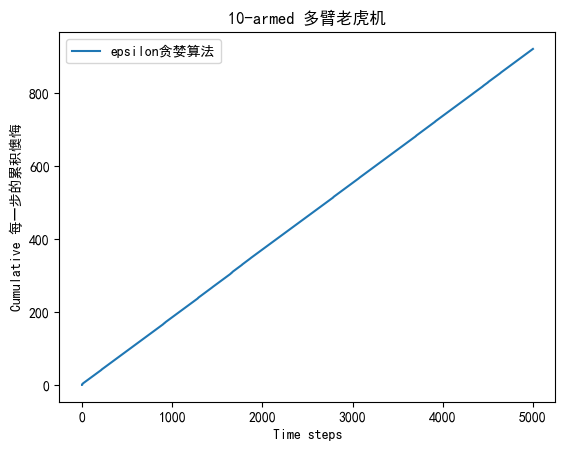

In [7]:
epsilon贪婪算法实例.运行(5000)
print('epsilon-贪婪算法的累积懊悔为：', epsilon贪婪算法实例.当前步的累积懊悔)
绘图([epsilon贪婪算法实例], ["epsilon贪婪算法"])

不同 epsilons 值的效果


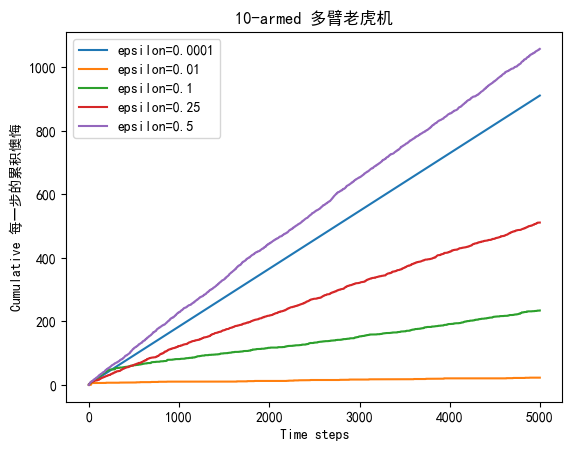

In [8]:
epsilons = [1e-4, 0.01, 0.1, 0.25, 0.5]
epsilon贪婪算法实例_list = [EpsilonGreedy(十臂老虎机, epsilon=e) for e in epsilons]
epsilon贪婪算法实例_names = ["epsilon={}".format(e) for e in epsilons]
for solver in epsilon贪婪算法实例_list:
    solver.运行(5000)

绘图(epsilon贪婪算法实例_list, epsilon贪婪算法实例_names)

epsilon值衰减的贪婪算法的累积懊悔为： 14.045832988632975


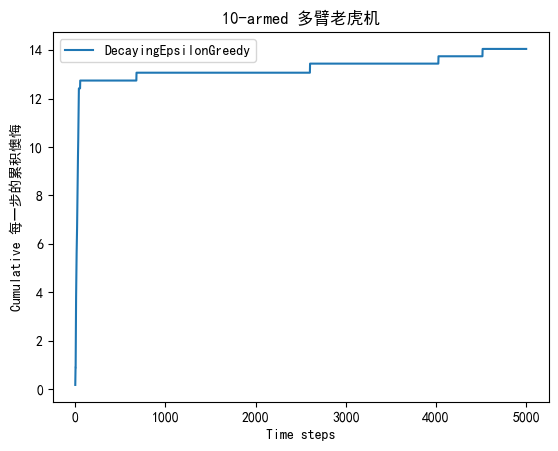

In [9]:
class DecayingEpsilonGreedy(测试算法基本框架):
    """ epsilon值随时间衰减的epsilon-贪婪算法 """
    def __init__(self, 多臂老虎机:伯努利多臂老虎机, 初始奖励=1.0):
        super(DecayingEpsilonGreedy, self).__init__(多臂老虎机)
        self.所有拉杆的期望奖励 = np.array([初始奖励] * self.多臂老虎机.拉杆个数)
        self.总计数 = 0

    def 运行1步(self):
        self.总计数 += 1
        if np.random.random() < 1 / self.总计数:  # epsilon值随时间衰减
            第几个拉杆 = np.random.randint(0, self.多臂老虎机.拉杆个数)
        else:
            第几个拉杆 = np.argmax(self.所有拉杆的期望奖励)

        奖励 = self.多臂老虎机.拉(第几个拉杆)
        self.所有拉杆的期望奖励[第几个拉杆] += 1. / (self.每根拉杆的尝试次数[第几个拉杆] + 1) * (奖励 - self.所有拉杆的期望奖励[第几个拉杆])

        return 第几个拉杆


decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(十臂老虎机)
decaying_epsilon_greedy_solver.运行(5000)
print('epsilon值衰减的贪婪算法的累积懊悔为：', decaying_epsilon_greedy_solver.当前步的累积懊悔)
绘图([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])

## 2.5 上置信界算法

设想这样一种情况：对于一台双臂老虎机，其中第一根拉杆只被拉动过一次，得到的奖励为 0；第二根拉杆被拉动过很多次，我们对它的奖励分布已经有了大致的把握。
上置信界算法核心思想：不确定性越高，探索的价值就越大。


上置信界算法的累积懊悔为： 56.67187478492471


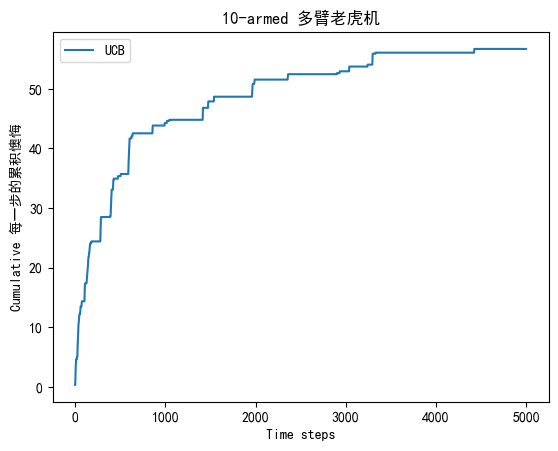

In [19]:
class UCB(测试算法基本框架):
    """ UCB 上置信界算法 """
    def __init__(self, 多臂老虎机:伯努利多臂老虎机, 系数, 初始奖励=1.0):
        super(UCB, self).__init__(多臂老虎机)
        self.总计数 = 0
        self.所有拉杆的期望奖励 = np.array([初始奖励] * self.多臂老虎机.拉杆个数)
        self.系数 = 系数

    def 运行1步(self):
        self.总计数 += 1
        ucb = self.所有拉杆的期望奖励 + self.系数 * np.sqrt(np.log(self.总计数) / (2 * (self.每根拉杆的尝试次数 + 1)))  # 计算上置信界
        第几个拉杆 = np.argmax(ucb)  # 选出上置信界最大的拉杆
        奖励 = self.多臂老虎机.拉(第几个拉杆)
        self.所有拉杆的期望奖励[第几个拉杆] += 1. / (self.每根拉杆的尝试次数[第几个拉杆] + 1) * (奖励 - self.所有拉杆的期望奖励[第几个拉杆])
        return 第几个拉杆



系数 = 1  # 控制不确定性比重的系数
UCB实例 = UCB(十臂老虎机, 系数)
UCB实例.运行(5000)
print('上置信界算法的累积懊悔为：', UCB实例.当前步的累积懊悔)
绘图([UCB实例], ["UCB"])

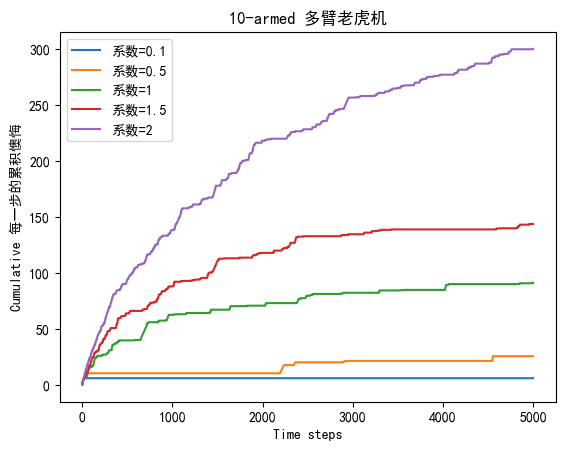

In [20]:
系数s = [0.1, 0.5, 1, 1.5, 2]
UCB算法实例_list = [UCB(十臂老虎机, 系数) for 系数 in 系数s]
UCB算法实例_names = ["系数={}".format(系数) for 系数 in 系数s]
for solver in UCB算法实例_list:
    solver.运行(5000)

绘图(UCB算法实例_list, UCB算法实例_names)

汤普森采样算法的累积懊悔为： 59.386634658005654


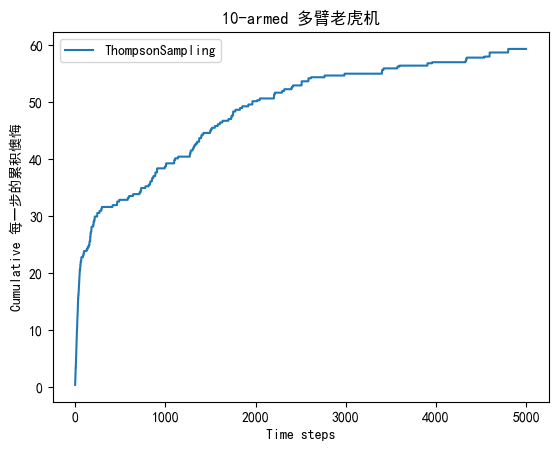

In [52]:
class ThompsonSampling(测试算法基本框架):
    """ 汤普森采样算法 """
    def __init__(self, 多臂老虎机:伯努利多臂老虎机):
        super(ThompsonSampling, self).__init__(多臂老虎机)
        self._a = np.ones(self.多臂老虎机.拉杆个数)  # 列表,表示每根拉杆奖励为1的次数
        self._b = np.ones(self.多臂老虎机.拉杆个数)  # 列表,表示每根拉杆奖励为0的次数

    def 运行1步(self):
        samples = np.random.beta(self._a, self._b)  # 按照Beta分布采样一组奖励样本
        第几个拉杆 = np.argmax(samples)  # 选出采样奖励最大的拉杆
        奖励 = self.多臂老虎机.拉(第几个拉杆)

        self._a[第几个拉杆] += 奖励  # 更新Beta分布的第一个参数
        self._b[第几个拉杆] += (1 - 奖励)  # 更新Beta分布的第二个参数
        return 第几个拉杆



thompson_sampling_solver = ThompsonSampling(十臂老虎机)
thompson_sampling_solver.运行(5000)
print('汤普森采样算法的累积懊悔为：', thompson_sampling_solver.当前步的累积懊悔)
绘图([thompson_sampling_solver], ["ThompsonSampling"])